In [22]:
!pip install pdfplumber
!pip install camelot-py[cv]
!pip install --upgrade pymupdf
!pip install google-generativeai
!pip install faiss-cpu
!pip install transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image
!pip install sentence_transformers

In [23]:
from dotenv import load_dotenv
import re
import os, glob
import pdfplumber
import camelot
import pymupdf
import numpy as np
import pandas as pd
from pathlib import Path
import google.generativeai as genai
import time
import faiss, json
import collections
import fitz
import io
from PIL import Image
import pytesseract
from langchain_core.documents import Document

load_dotenv()

True

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [24]:
# Example:
# os.environ['GEMINI_API_KEY'] = 'your-key-here'
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

COMPANY_NAME = "Google"

## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


In [25]:
DATA_DIR = "00-data"

# Annual reports (10-Ks)
annual_files = glob.glob(f"{DATA_DIR}/annuals/*.pdf")

# # Quarterly reports (10-Qs)
quarterly_files = glob.glob(f"{DATA_DIR}/quarterlies/*.pdf")

# # Press releases
# press_files = glob.glob(f"{DATA_DIR}/press_releases/*.pdf")

# Presentations
presentation_files = glob.glob(f"{DATA_DIR}/presentations/*.pdf")

# Supplements
supplement_files = glob.glob(f"{DATA_DIR}/supplements/*.pdf")

# # Transcripts
# transcript_files = glob.glob(f"{DATA_DIR}/transcripts/*.pdf")

In [26]:
# for folder in ["annuals", "quarterlies", "press_releases", "presentations", "supplements", "transcripts"]:
for folder in ["annuals", "quarterlies", "presentations", "supplements"]:

    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    print(f"{folder}: {len(files)} files")

annuals: 2 files
quarterlies: 8 files
presentations: 2 files
supplements: 0 files


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

### Embeddings

In [27]:
from sentence_transformers import SentenceTransformer, util

# load E5-base-v2
model = SentenceTransformer("intfloat/e5-base-v2")

def embed_text_query(s):
    # E5 expects prefix, and stripping/normalizing helps
    return model.encode(f"query: {s.strip().lower()}", normalize_embeddings=True)

def embed_text_passage(s):
    # E5 expects prefix, and stripping/normalizing helps
    return model.encode([f"passage: {chunk_text.strip().lower()}" for chunk_text in s],
                        convert_to_numpy=True,
                        normalize_embeddings=True,
                        show_progress_bar=True)

### Ingestion pipeline (Table)

In [28]:
# TODO: Implement ingestion pipeline (TABLE)
def extract_tables_from_page(pdf_path, page_num):
    """
    Extract tables from a PDF page by detecting colored header fills.
    """

    # Load the document and page
    doc = pymupdf.open(pdf_path)
    page = doc[page_num - 1]
    page_height = page.rect.height

    def is_nonwhite(rgb, thr=0.05):
        r, g, b = rgb
        return abs(1-r) + abs(1-g) + abs(1-b) > thr

    # --- 1. Get all fills ---
    fills = [
        (d["rect"], d["fill"]) for d in page.get_drawings()
        if d["type"] == "f" and d.get("fill")
    ]

    # --- 2. Keep only colored fills (blue/gray) ---
    colored = [f for f in fills if is_nonwhite(f[1]) and f[0].x1 - f[0].x0 > 100]
    colored.sort(key=lambda f: f[0].y0)

    # --- 3. Group colored fills into tables ---
    tables = []
    if colored:
        cur = [colored[0]]
        for f in colored[1:]:
            if abs(f[0].y0 - cur[-1][0].y1) < 25:  # stacked fills = same table
                cur.append(f)
            else:
                tables.append(cur)
                cur = [f]
        tables.append(cur)

    # --- 4. Process each detected table ---
    extracted_tables = []

    for idx, tgroup in enumerate(tables, 1):
        first_color = tgroup[0]
        y_bottom = max(f[0].y1 for f in tgroup) + 10
        y_top = first_color[0].y0

        # Find header region above this table
        header_y0 = y_top - 40
        x_left = min(f[0].x0 for f in tgroup)
        x_right = max(f[0].x1 for f in tgroup) + 100

        clip = pymupdf.Rect(x_left, header_y0 - 5, x_right, y_bottom + 5)

        try:
            # Convert clip to Camelot coords
            y1_cam = page_height - clip.y1
            y2_cam = page_height - clip.y0
            table_area = f"{clip.x0},{y1_cam},{clip.x1},{y2_cam}"

            tables_camelot = camelot.read_pdf(
                pdf_path,
                flavor="stream",
                table_areas=[table_area],
                pages=str(page_num)
            )

            if tables_camelot:
                # print(f"Camelot Table {idx} extracted")
                df = tables_camelot[0].df
                extracted_tables.append({
                    'source': pdf_path,
                    'table_num': idx,
                    'page': page_num,
                    'clip': clip,
                    'dataframe': df
                })
            else:
                print(f"Table {idx}: No table found")
        except Exception as e:
            print(f"Table {idx} failed: {e}")

    doc.close()
    return extracted_tables

### Ingestion pipeline (Text)

In [29]:
# --- Helpers ---
def clean_table(table):
    """Clean raw Camelot table output."""
    print ("Raw table:", table)
    return [
        [(cell or "").strip().replace("\n", " ") for cell in row]
        for row in table
    ]

def _normalize(s: str) -> str:
    s = (s or "").lower()
    # unify whitespace & quotes
    s = s.replace("\n", " ").replace("’", "'").replace("–", "-").replace("—", "-")
    s = " ".join(s.split())
    return s


def is_valid_table(table, numeric_threshold: float = 0.25) -> bool:
    """Return True if the table has enough numeric-looking cells to be considered real data."""
    if not table or not table[0]:
        return False

    cells = sum(len(r) for r in table)
    numeric_cells = 0
    num_pattern = re.compile(r"^\(?[+-]?\d[\d,\.]*\)?$")  # matches 5,439 or (1,200) etc.

    for row in table:
        for cell in row:
            cell = str(cell).strip().replace("$", "").replace("%", "")
            if num_pattern.match(cell):
                numeric_cells += 1

    return (numeric_cells / cells) >= numeric_threshold

In [30]:
# @title
# TODO: Implement ingestion pipeline (TEXT)
SECTION_EXAMPLES = {
    # --- Cover / Administrative ---
    "cover_page": [
        "united states securities and exchange commission form 10 k annual report pursuant to section 13 or 15d",
        "united states securities and exchange commission form 10 q quarterly report pursuant to section 13 or 15d",
        "cover page showing registrant name commission file number and state of incorporation",
        "front page identifying registrant address telephone number and fiscal year end",
    ],

    # --- Management Discussion ---
    "mdna": [
        "managements discussion and analysis of financial condition and results of operations",
        "md&a explaining liquidity capital resources and operating performance",
        "discussion and analysis of results of operations comparing current and prior periods",
        "analysis of changes in revenues costs cash flows and capital expenditures",
    ],

    # --- Risk Factors ---
    "risk_factors": [
        "risk factors that may affect future financial performance or share price",
        "discussion of material risks and uncertainties facing the company",
        "factors that could cause actual results to differ materially from forward looking statements",
    ],

    # --- Financial Highlights / Summary Data ---
    "summary_financial_data": [
        "selected financial data summarizing key performance indicators for the past five years",
        "summary of consolidated financial information and operating results",
        "selected financial highlights including revenue net income and earnings per share",
    ],

    # --- Income Statement ---
    "income_statement": [
        "consolidated statements of income showing revenue expenses and net income",
        "statement of operations or profit and loss reporting revenues and operating income",
        "consolidated statements of comprehensive income including other comprehensive income items",
        "income statement presenting total revenues cost of goods sold gross profit and net earnings",
    ],

    # --- Balance Sheet ---
    "balance_sheet": [
        "consolidated balance sheets showing assets liabilities and shareholders equity",
        "statement of financial position listing current assets long term liabilities and total equity",
        "balance sheet detailing cash accounts receivable inventories property plant and equipment",
    ],

    # --- Cash Flow Statement ---
    "cash_flow": [
        "consolidated statements of cash flows showing cash inflows and outflows from operating investing and financing activities",
        "statement of cash flows reconciling net income to net cash provided by operating activities",
        "cash flow statement detailing capital expenditures debt repayment and dividend payments",
    ],

    # --- Shareholders’ Equity ---
    "equity": [
        "consolidated statements of shareholders equity showing changes in retained earnings dividends and stock issuance",
        "statement of changes in stockholders equity presenting share repurchases and comprehensive income",
        "equity statement showing common stock treasury stock retained earnings and accumulated other comprehensive income",
    ],

    # --- Notes to Financial Statements ---
    "financial_statements": [
        "notes to consolidated financial statements providing accounting policies commitments contingencies and segment information",
        "footnotes accompanying consolidated financial statements describing significant accounting policies",
        "notes to financial statements detailing income taxes stock compensation and earnings per share",
        "supplementary information supporting consolidated financial statements",
    ],

    # --- Market Risk Disclosures ---
    "market_risk_disclosures": [
        "quantitative and qualitative disclosures about market risk",
        "discussion of exposure to interest rate foreign currency commodity and credit risk",
        "sensitivity analysis of market risk instruments",
    ],

    # --- Controls and Procedures ---
    "controls_procedures": [
        "controls and procedures section discussing disclosure controls and internal control over financial reporting",
        "evaluation of disclosure controls and procedures and changes in internal control",
        "managements report on internal control over financial reporting",
    ],

    # --- Legal Proceedings ---
    "legal_proceedings": [
        "description of material pending legal proceedings and litigation",
        "legal proceedings section detailing lawsuits claims and regulatory actions",
        "information about legal matters affecting the company",
    ],

    # --- Segment Information ---
    "segment_info": [
        "segment information describing operating segments geographic areas and major customers",
        "disclosure of business segments including revenue and profit by segment",
        "note providing details of segment performance and intersegment eliminations",
    ],

    # --- Signatures ---
    "signatures": [
        "signatures section signed on behalf of the registrant and principal officers",
        "signatures of directors executive officers and principal accounting officer",
        "signed by the registrant pursuant to the securities exchange act of 1934",
    ],

    # --- Exhibits ---
    "exhibits": [
        "exhibits and financial statement schedules",
        "list of exhibits and certifications required by form 10k or 10q",
        "exhibit index listing contracts and subsidiary information",
    ],

    # --- Fallback ---
    "other": [
        "miscellaneous sections not classified elsewhere including general disclosures appendices or cover letters",
    ],
}

In [31]:
SECTION_EMBS = {
    sec: [embed_text_query(ex) for ex in examples]
    for sec, examples in SECTION_EXAMPLES.items()
}


def classify_section(text, table):
    page_text = _normalize(text)
    headers = _normalize(" ".join(table[0])) if table else ""
    first_col = _normalize(" ".join(row[0] for row in table[1:])) if table else ""

    combined = f"{page_text} {headers} {first_col}"
    emb = embed_text_query(combined)

    scores = {
        sec: max(util.cos_sim(emb, e).item() for e in embs)
        for sec, embs in SECTION_EMBS.items()
    }

    best = max(scores, key=scores.get)
    return best if scores[best] > 0.35 else "other"

In [32]:
pdf_path = []
for folder in ["annuals", "quarterlies", "supplements"]:
    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    pdf_path.extend(files)

print(f"Processing {len(pdf_path)} PDFs from all folders")
print("PDF paths:", pdf_path[:3], "...")

# keep track sections
sections = {}
output = {}

for pdfFile in pdf_path:
    pdf_name = os.path.basename(pdfFile)
    output[pdf_name] = {}

    print(f"\n=== Processing: {pdf_name} ===")

    # Step 1: extract raw text with pdfplumber
    with pdfplumber.open(pdfFile) as pdf:
        for i, page in enumerate(pdf.pages, start=1):
            text = page.extract_text() or ""
            section_text = classify_section(text, [[]])  # classifying page text only without tables
            sections[section_text] = sections.get(section_text, 0) + 1

            # Step 2: extract tables
            tables_pymupdf = extract_tables_from_page(pdfFile, i)

            tables = []
            for t in tables_pymupdf:
                df = t["dataframe"]
                raw_table = df.values.tolist()

                # if not is_valid_table(raw_table):
                #     # Skip tables that are mostly text, like footnotes or headers
                #     print(f"[SKIP] Page {i} – Non-numeric table filtered out")
                #     continue

                cleaned_table = clean_table(raw_table)
                section_table = classify_section(text, cleaned_table)

                # Track section counts
                sections[section_table] = sections.get(section_table, 0) + 1

                # Skip noise like signatures
                if section_table == "other" and "signature" in text.lower():
                    continue

                markdown_text = pd.DataFrame(cleaned_table).to_markdown(index=False)

                tables.append({
                    "section": section_table,
                    "header" : cleaned_table[0] if cleaned_table else [],
                    "rows" : cleaned_table[1:] if len(cleaned_table) > 1 else [],
                    "markdown": markdown_text
                })

            print(f"Page {i} → Text length: {len(text) if text else 0}, Tables Kept: {len(tables)}")

            output[pdf_name][i] = {
                "page_section": section_text,
                "text": text,
                "tables": tables
            }

print ("Section distribution:", sections)

# Step 3: Create directory if it doesn't exist and dump to JSON
output_path = f"{DATA_DIR}/test.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    json.dump(output, f, indent=4)

print(f"\nOutput saved to: {output_path}")

Processing 10 PDFs from all folders
PDF paths: ['00-data/annuals\\goog-10-k-2023-final.pdf', '00-data/annuals\\goog-10-k-2024.pdf', '00-data/quarterlies\\goog-10-q-q1-2023.pdf'] ...

=== Processing: goog-10-k-2023-final.pdf ===
Page 1 → Text length: 2689, Tables Kept: 0
Page 2 → Text length: 3256, Tables Kept: 0
Page 3 → Text length: 1439, Tables Kept: 0
Page 4 → Text length: 3836, Tables Kept: 0
Page 5 → Text length: 4988, Tables Kept: 0
Page 6 → Text length: 5387, Tables Kept: 0
Page 7 → Text length: 4960, Tables Kept: 0
Page 8 → Text length: 4765, Tables Kept: 0
Page 9 → Text length: 4034, Tables Kept: 0
Page 10 → Text length: 5339, Tables Kept: 0
Page 11 → Text length: 5262, Tables Kept: 0
Page 12 → Text length: 5572, Tables Kept: 0
Page 13 → Text length: 5822, Tables Kept: 0
Page 14 → Text length: 5441, Tables Kept: 0
Page 15 → Text length: 5912, Tables Kept: 0
Page 16 → Text length: 5236, Tables Kept: 0
Page 17 → Text length: 6050, Tables Kept: 0
Page 18 → Text length: 6081, Tabl

In [33]:
# Step 3: Create directory if it doesn't exist and dump to JSON
output_path = f"{DATA_DIR}/test.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w") as f:
    json.dump(output, f, indent=4)

print(f"\nOutput saved to: {output_path}")


Output saved to: 00-data/test.json


### Ingestion pipeline (Slides)

In [34]:
# TODO: Implement ingestion pipeline (SLIDES)

def extract_slides_fitz(pdf_path, output_dir, lower_crop_extra=200):
    os.makedirs(output_dir, exist_ok=True)
    pdf = fitz.open(pdf_path)
    print(f"[INFO] Loaded '{pdf_path}' with {len(pdf)} pages.")

    for i, page in enumerate(pdf, start=1):
        pix = page.get_pixmap(dpi=200)
        img = Image.open(io.BytesIO(pix.tobytes("png")))

        # Crop lower for slides 1–2
        if i in [1, 2]:
            w, h = img.size
            crop_box = (0, 0, w, min(h + lower_crop_extra, h))
            img = img.crop(crop_box)

        img.save(os.path.join(output_dir, f"slide_{i:02d}.png"), "PNG")

    print(f"Extracted {len(pdf)} slides from {pdf_path}")

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
def ocr_folder(folder, label):
    docs = []
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".png"):
            path = os.path.join(folder, fname)
            text = pytesseract.image_to_string(Image.open(path))
            if text.strip():
                docs.append(Document(
                    page_content=text,
                    metadata={"image_path": path, "source_report": label}
                ))
    return docs

In [35]:
# Extract slides and OCR
pdf_path = []
for folder in ["presentations"]:
    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    pdf_path.extend(files)

print(f"Processing {len(pdf_path)} PDFs from all folders")

docs = []
for pdf in pdf_path:
    # Create output folder based on PDF name
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    slide_folder = f"{DATA_DIR}/presentations/slides_{pdf_name}"
    
    print(f"Extracting slides from {pdf_name}...")
    extract_slides_fitz(pdf, slide_folder)
    
    # OCR the extracted slides
    pdf_docs = ocr_folder(slide_folder, pdf_name)
    docs.extend(pdf_docs)

print(f"Loaded {len(docs)} slide documents from {len(pdf_path)} PDFs.")

Processing 2 PDFs from all folders
Extracting slides from 2025q1-alphabet-earnings-slides...
[INFO] Loaded '00-data/presentations\2025q1-alphabet-earnings-slides.pdf' with 10 pages.
Extracted 10 slides from 00-data/presentations\2025q1-alphabet-earnings-slides.pdf
Extracting slides from 2025q2-alphabet-earnings-slides...
[INFO] Loaded '00-data/presentations\2025q2-alphabet-earnings-slides.pdf' with 10 pages.
Extracted 10 slides from 00-data/presentations\2025q2-alphabet-earnings-slides.pdf
Loaded 20 slide documents from 2 PDFs.


### Chunk

#### Text + Tables

In [36]:
# load the json file
with open(f"{DATA_DIR}/test.json", "r") as f:
    doc = json.load(f)

chunks = []

for fileDoc , docContent in doc.items():
    for page_num, content in docContent.items():
        page_section = content.get("page_section", "unknown")
        text = content.get("text", "")
        tables = content.get("tables", [])

        if text.strip():
            chunks.append({
                "id": f"{fileDoc}-page-{page_num}-text",
                "text": f"Financial filing text section: {text}",
                "metadata": {"document": fileDoc, "page_number": page_num, "page_section": page_section, "chunk_type": "prose"}
            })

        if tables:
            for t_index, table in enumerate(tables):
                    table_text = "\n".join([", ".join(row) for row in table.get("rows", [])])
                    table_markdown = table.get("markdown", "")

                    chunks.append({
                        "id": f"{fileDoc}-page-{page_num}-table-{t_index}",
                        "text": f"Financial statement table: {table_text}",
                        "markdown": table_markdown,
                        "metadata": {
                            "document": fileDoc,
                            "page_number": page_num,
                            "page_section": page_section,
                            "chunk_type": "table",
                            "table_index": t_index
                            }
                    })

print(f"Created {len(chunks)} chunks")

Created 1355 chunks


In [ ]:
text = [ chunk["text"] for chunk in chunks ]

embeddings = embed_text_passage (text)

print (f"Embeddings shape: {embeddings.shape}")

# Create a FAISS index - IP for normalized embeddings
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
print (f"FAISS index contains {index.ntotal} vectors.")

# save it locally
output_dir = f"{DATA_DIR}/base"
os.makedirs(output_dir, exist_ok=True)

# storing the index
faiss.write_index(index, f"{output_dir}/base.faiss")
print(f"Index saved to {output_dir}/base.faiss")

# store the chunks
with open(f"{DATA_DIR}/base/chunks.json", "w") as f:
    json.dump(chunks, f, indent=4)

#### Slides

In [38]:
# Extract slides and OCR (already extracted, just need to OCR)
docs_q1 = ocr_folder(f"slides_q1_2025", "Q1_2025")
docs_q2 = ocr_folder(f"slides_q2_2025", "Q2_2025")
docs = docs_q1 + docs_q2
print(f"Loaded {len(docs)} slide documents.")

slide_chunks = []
for doc in docs:
    # Extract slide number from filename (e.g., "slide_01.png" -> 1)
    filename = os.path.basename(doc.metadata['image_path'])
    slide_num = int(filename.split('_')[1].split('.')[0])
    
    slide_chunks.append({
        "id": f"{doc.metadata['source_report']}-slide-{slide_num:02d}",
        "text": doc.page_content,
        "metadata": {
            "source_report": doc.metadata['source_report'],
            "image_path": doc.metadata['image_path'],
            "slide_number": slide_num,
            "chunk_type": "slide"
        }
    })

print(f"Created {len(slide_chunks)} slide chunks.")

Loaded 20 slide documents.
Created 20 slide chunks.


In [ ]:
slide_texts = [doc.page_content for doc in docs]

slide_embeddings = embed_text_passage (slide_texts)

print (f"Slide Embeddings shape: {slide_embeddings.shape}")

# Create a FAISS index - IP for normalized embeddings
slide_index = faiss.IndexFlatIP(slide_embeddings.shape[1])
slide_index.add(slide_embeddings)
print (f"FAISS index contains {slide_index.ntotal} vectors.")

# save it locally
output_dir = f"{DATA_DIR}/base"
os.makedirs(output_dir, exist_ok=True)

# storing the index
faiss.write_index(slide_index, f"{output_dir}/slides.faiss")
print(f"Index saved to {output_dir}/slides.faiss")

with open(f"{output_dir}/chunks_slides.json", "w") as f:
    json.dump(slide_chunks, f)

### Retrieval

In [40]:
index = {}

def init_indexes():
    global index

    # Load base index
    documents_base_dir = f"{DATA_DIR}/base/base.faiss"
    index["index"] = faiss.read_index(documents_base_dir)
    index["chunks"] = json.load(open(f"{DATA_DIR}/base/chunks.json"))

    # Load slides index
    documents_slides_dir = f"{DATA_DIR}/base/slides.faiss"
    index["slides_index"] = faiss.read_index(documents_slides_dir)
    index["chunks_slides"] = json.load(open(f"{DATA_DIR}/base/chunks_slides.json"))

    print (f"chunks type : {type(index['chunks'])}, length: {len(index['chunks'])}")
    print (f"chunks_slides type : {type(index['chunks_slides'])}, length: {len(index['chunks_slides'])}")

def search_query(query, k=5):
    global index
    query_embedding = embed_text_query(query)  # Convert query to vector

    D, I = index["index"].search(np.array([query_embedding]), k=k)
    # D = distances/scores
    # I = indices of top k matching chunks

    results = [
        {
            "rank": rank + 1,
            "score": float(D[0][rank]),
            "text": index["chunks"][identified_chunk_idx]["text"],
            "markdown": index["chunks"][identified_chunk_idx].get("markdown", ""),
            "metadata": index["chunks"][identified_chunk_idx]["metadata"]
        }
        for rank, identified_chunk_idx in enumerate(I[0])
    ]

    return results

In [41]:
def search_slides_query(query, k=3):
    global index
    query_embedding = embed_text_query(query)  # Convert query to vector

    D, I = index["slides_index"].search(np.array([query_embedding]), k=k)
    # D = distances/scores
    # I = indices of top k matching chunks

    results = [
        {
            "rank": rank + 1,
            "score": float(D[0][rank]),
            "text": index["chunks_slides"][identified_chunk_idx]["text"],
            "metadata": index["chunks_slides"][identified_chunk_idx]["metadata"]
        }
        for rank, identified_chunk_idx in enumerate(I[0])
    ]

    return results

#### Output print helper

In [42]:
from textwrap import shorten
from tabulate import tabulate

def pretty_print_results(results, show_table=False):
    table_data = []
    for r in results:
        meta = r["metadata"]
        chunk_type = meta.get("chunk_type", "unknown")
        section = meta.get("page_section", "unknown")
        doc = meta.get("document", "unknown")
        page = meta.get("page_number", "?")
        score = f"{r['score']:.3f}"
        
        # shorten text for preview
        preview = shorten(r['text'], width=120, placeholder="…")
        table_data.append([r['rank'], score, chunk_type, section, doc, page, preview])

    headers = ["Rank", "Score", "Type", "Section", "Document", "Page", "Preview"]
    print(tabulate(table_data, headers=headers, tablefmt="github"))

    # print markdown tables
    if show_table:
        for r in results:
            if r["metadata"]["chunk_type"] == "table" and r.get("markdown"):
                print(f"\n Table from {r['metadata']['document']} (p.{r['metadata']['page_number']}):\n")
                print(r["markdown"])
                print("\n" + "-"*80 + "\n")


In [43]:
# Initialize once
init_indexes()

# Search
results = search_query("Q1 2024 revenue", k=5)

# print(results)
pretty_print_results(results, show_table=True)

chunks type : <class 'list'>, length: 1355
chunks_slides type : <class 'list'>, length: 20
|   Rank |   Score | Type   | Section                | Document              |   Page | Preview                                                                                                                 |
|--------|---------|--------|------------------------|-----------------------|--------|-------------------------------------------------------------------------------------------------------------------------|
|      1 |   0.851 | prose  | cash_flow              | goog-10-q-q1-2024.pdf |     33 | Financial filing text section: Other Information • On April 25, 2024, the Board of Directors of Alphabet approved the…  |
|      2 |   0.848 | prose  | income_statement       | goog-10-q-q1-2024.pdf |     11 | Financial filing text section: Table of Contents Alphabet Inc. Note 2. Revenues Disaggregated Revenues The following…   |
|      3 |   0.848 | prose  | summary_financial_data | goog-10-q-q1-2

#### Slides Query


--- Result 1 ---
Score: 0.8671
Caption: Q1 2025 Earnings Alphabet

Alphabet Revenues and Operating Income

in Millions, except Percentages; unaudited

$100,000
=
$90,234 =
= $90,000 = $40,000
2 s
2 $80,539 g $30,606
a2 $30,000
<= $80,000 8 $25,472
$s £
co
@ $70,000 2 $20,000
® @
“ ®
$60,000 2 $10,000
fe)
$50,000 $0
Q1'24 Q1’25 Q1'24 125
Y/Y Growth +15% +12%

Operating Margin 31.6% 33.9%



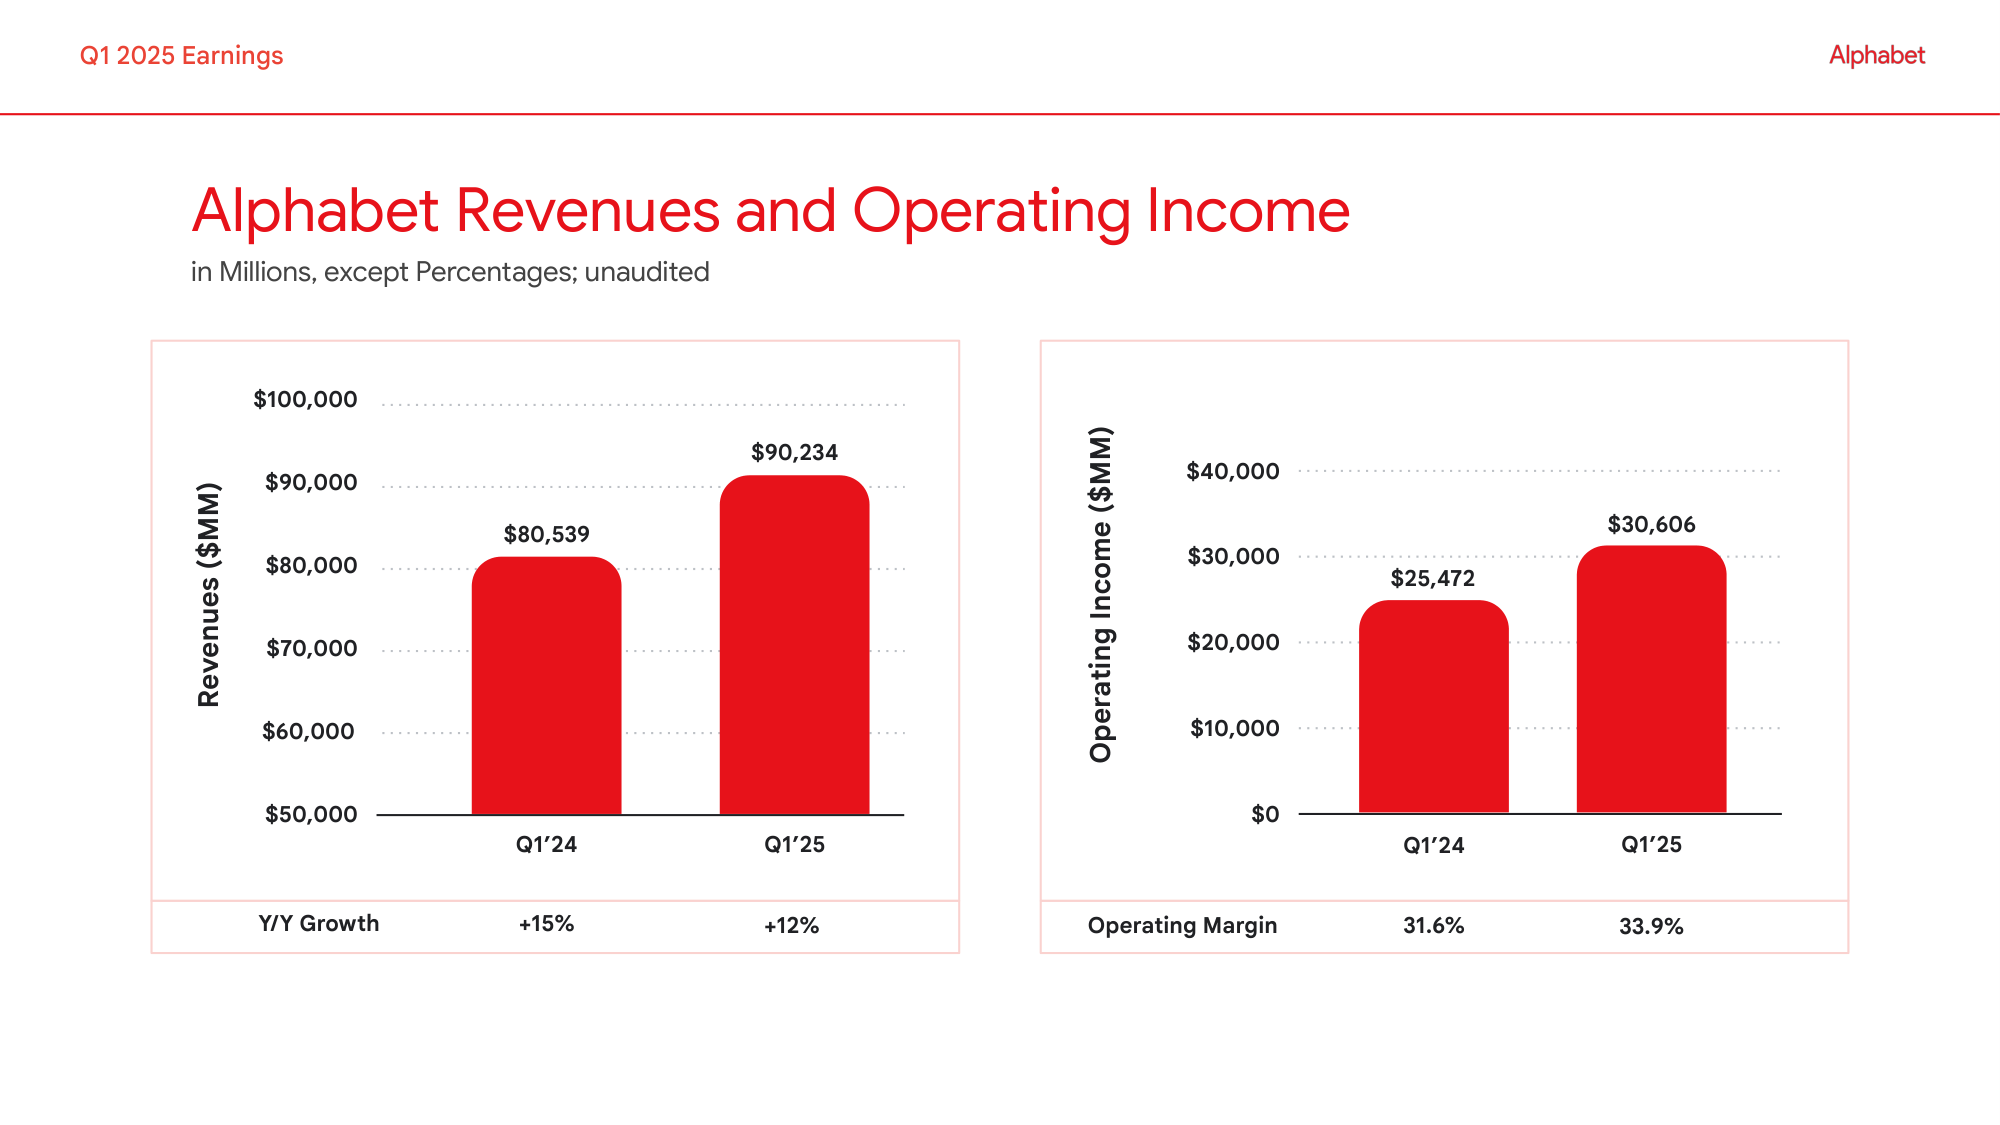


--- Result 2 ---
Score: 0.8660
Caption: Alphabet
Q@1 2025 Earnings

April 24, 2025



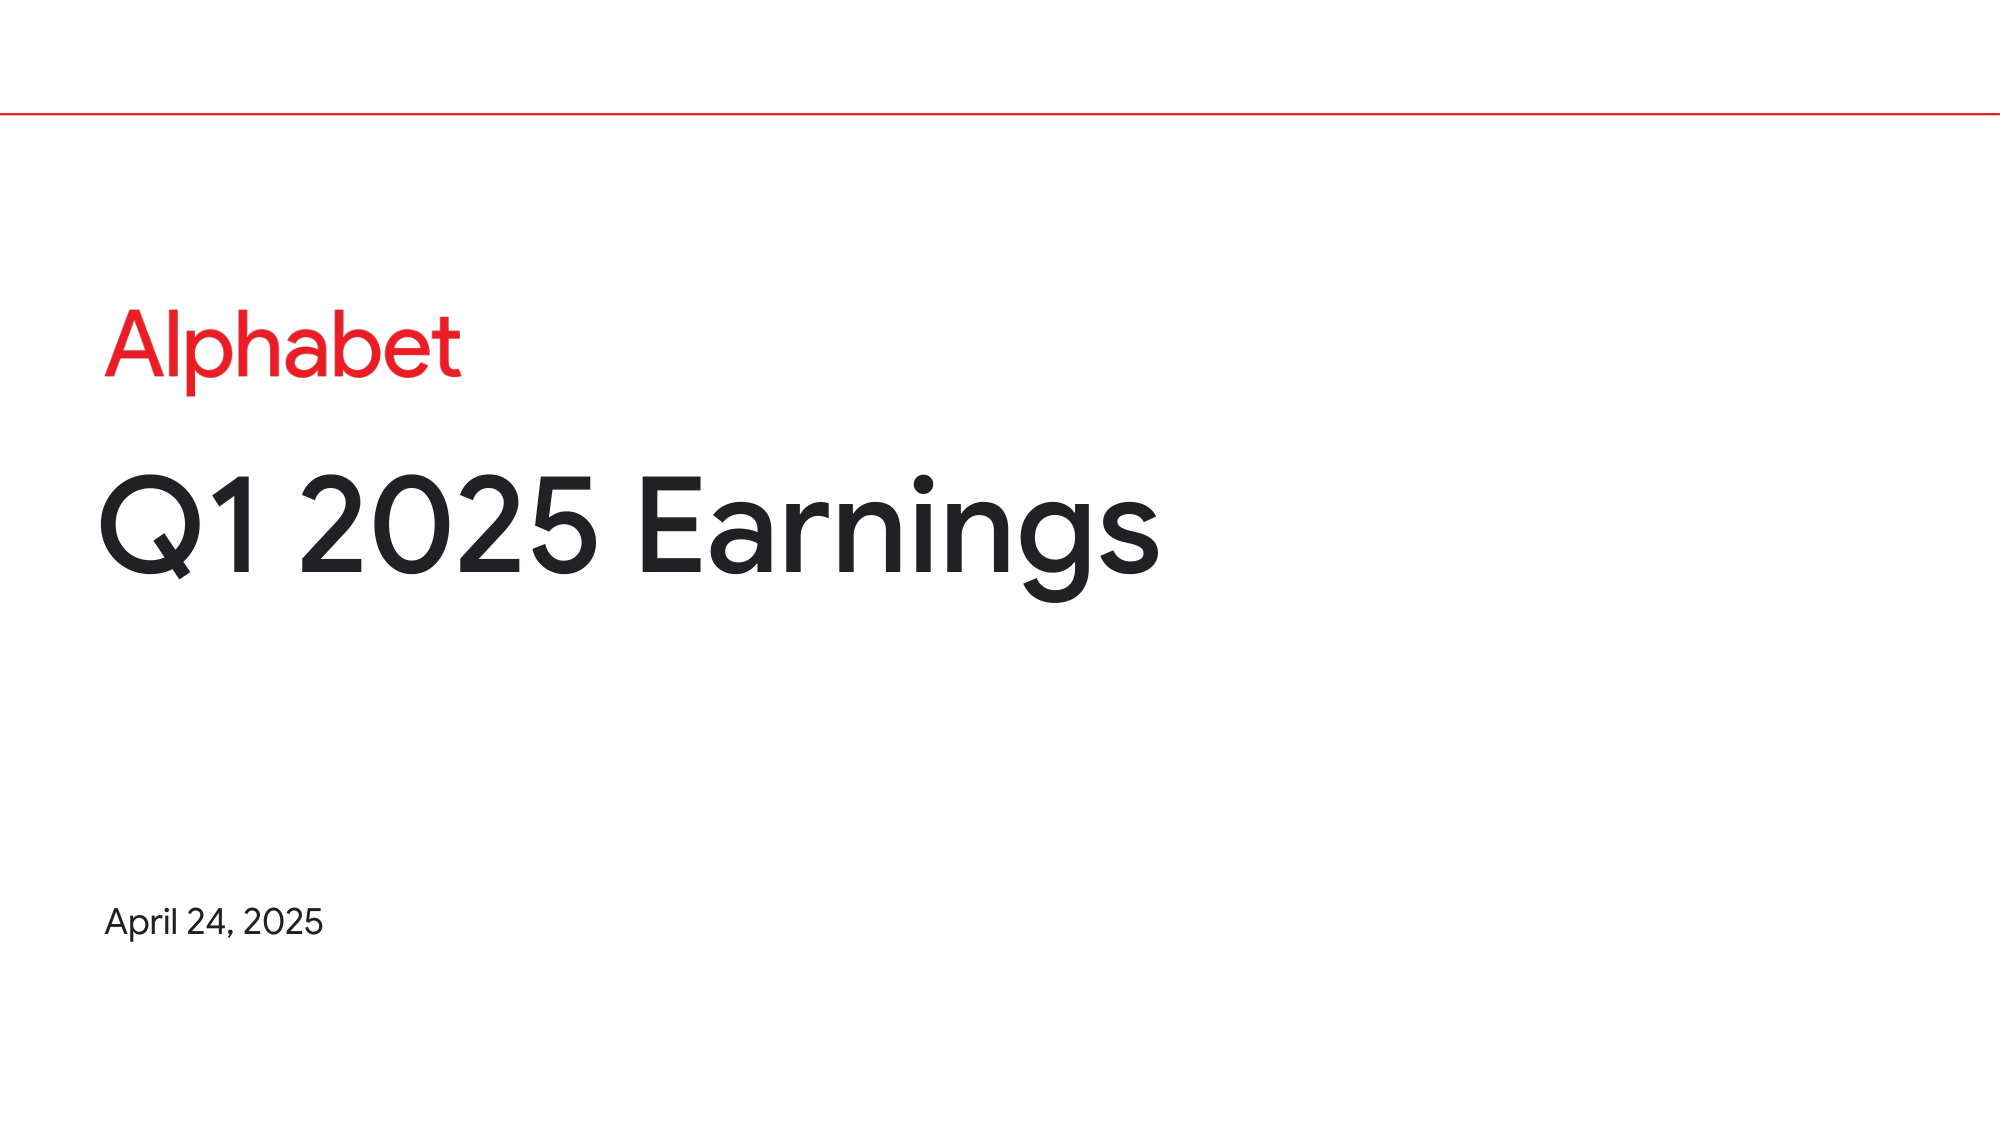


--- Result 3 ---
Score: 0.8651
Caption: Q1 2025 Earnings

Alphabet

Note About Forward-Looking Statements and
Non-GAAP Financial Measures

This presentation may contain forward-looking statements regarding our business, operations, and
financial performance. Such statements are based on current expectations and assumptions that are
subject to a number of risks and uncertainties. Actual results could differ materially. Please refer to our
Forms 10-K and 10-Q, including the risk factors. We undertake no obligation to update any forward-looking
statement, except as required by law. Given these risk and uncertainties, investors are cautioned not to
place undue reliance on such forward-looking statements.

We present both GAAP and non-GAAP financial measures in this presentation. A reconciliation of
non-GAAP to GAAP measures is included in this presentation and in the most recent earnings press
release, which is distributed and available to the public through our Investor Relations website

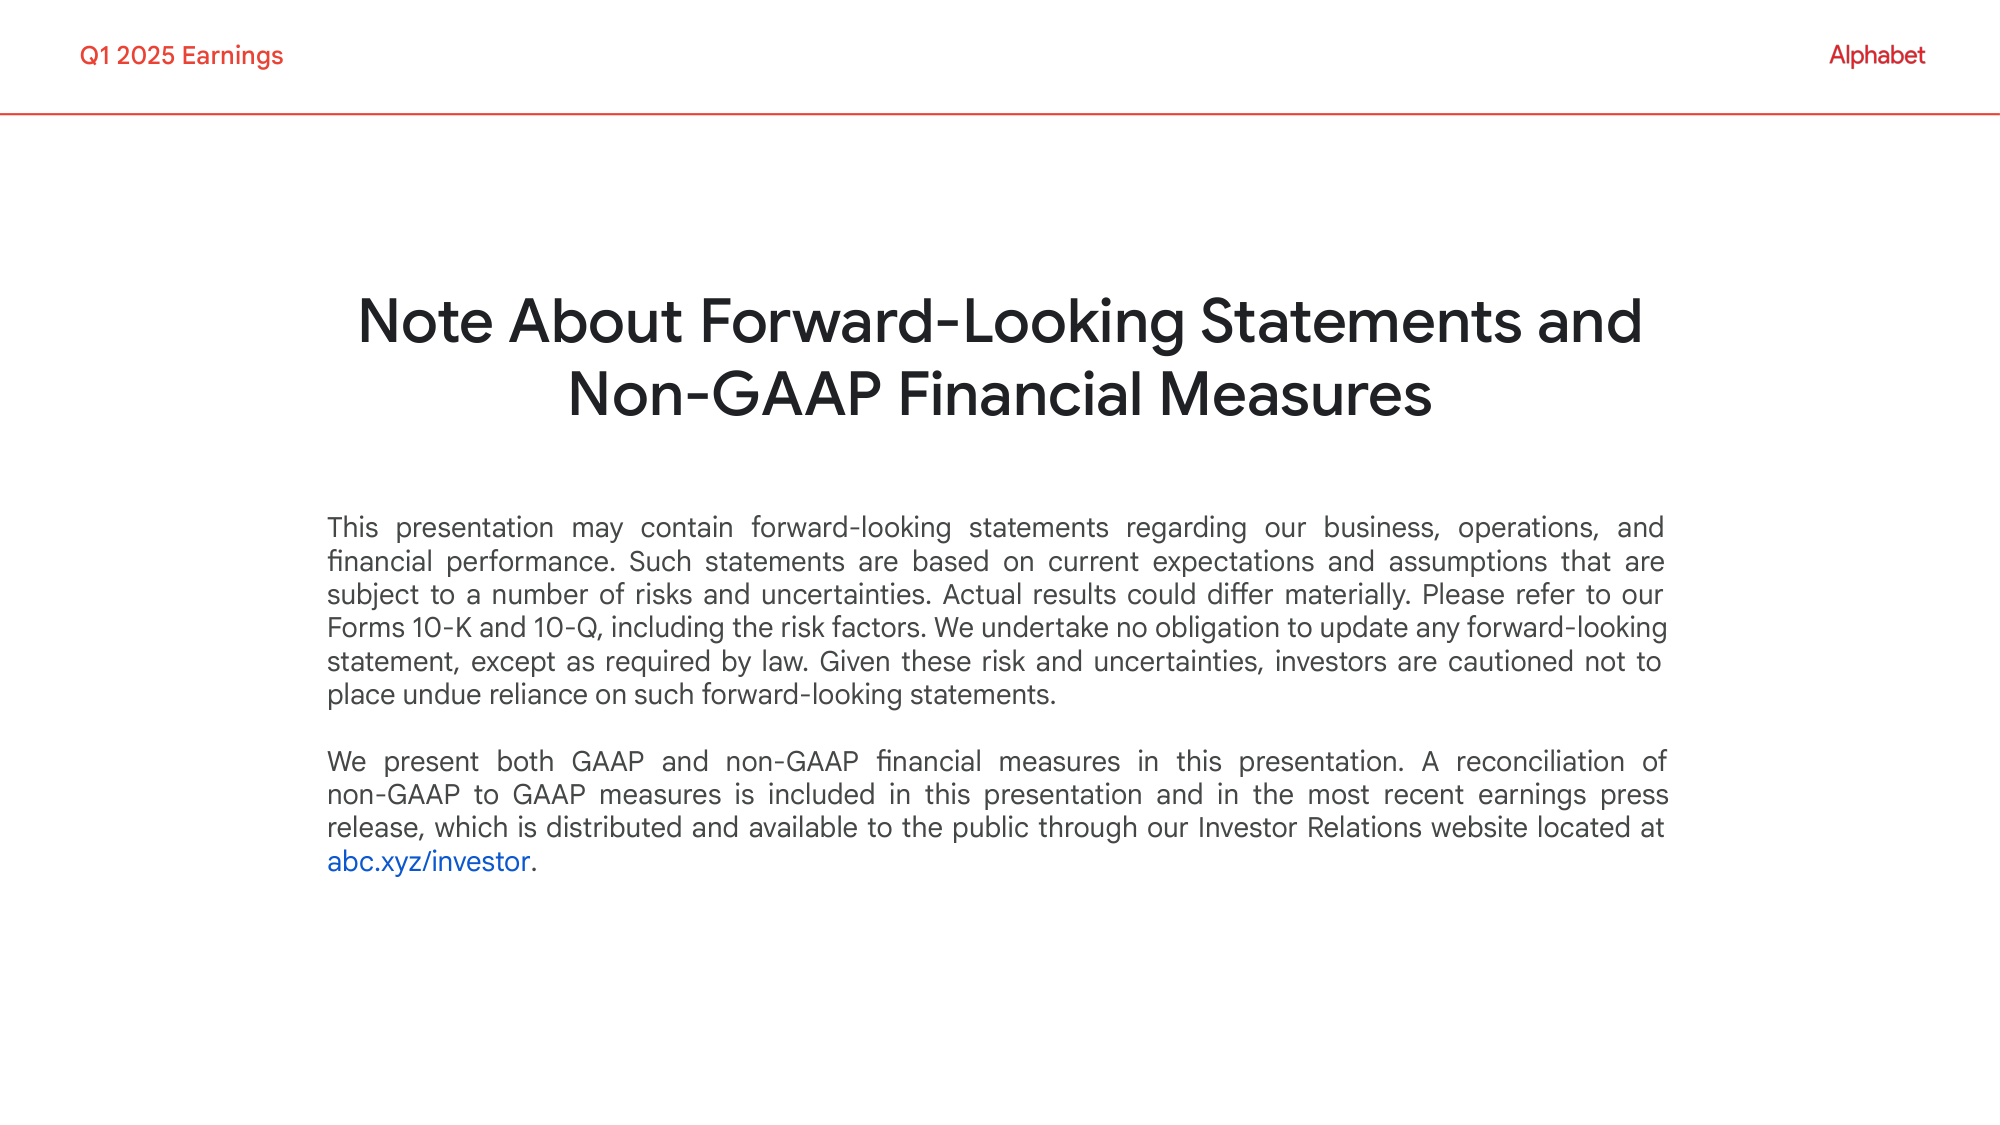

In [60]:
from IPython.display import Image, display
import os

query = "2025 Q1 revenue"
results = search_slides_query(query, k=3)

for r in results:
    print(f"\n--- Result {r['rank']} ---")
    print(f"Score: {r['score']:.4f}")
    print("Caption:", r["text"])
    
    image_path = r["metadata"].get("image_path")
    if image_path and os.path.exists(image_path):
        display(Image(filename=image_path, width=600))
    else:
        print("(Image not found)")


## 4. Baseline Pipeline

### Agent Config and Imports

In [44]:
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor
from langchain.chains import LLMMathChain
from langchain.schema import SystemMessage, HumanMessage

In [ ]:
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0) 

# guiding prompt
system_prompt = """
You are a financial analyst assistant that can use tools.

When given retrieved data:
1. Identify all relevant components (e.g., for Operating Expenses: R&D, Sales & Marketing, G&A)
2. Extract the values for the requested years
3. Calculate using standard financial formulas
4. Cite each component source

If data is incomplete, state what's missing.
"""

#### Retriever Tool

In [46]:
@tool("retriever", return_direct=False)
def retriever_tool(query: str) -> str:
    """Retrieve the most relevant text or table snippets for a given finance question."""
    results = search_query(query, k=5)
    formatted = []
    for r in results:
        meta = r["metadata"]
        src = f"{meta['document']} (p.{meta['page_number']}) [{meta['page_section']}]"
        formatted.append(f"{src}\n{r['text'][:800]}")
    return "\n\n---\n\n".join(formatted)


In [47]:
def search_tables_only(query: str, k: int = 5) -> str:
    """Retrieve ONLY tables for structured financial data"""
    search_k = k * 2
    
    query_embedding = embed_text_query(query)
    D, I = index["index"].search(np.array([query_embedding]), k=search_k)

    # Filter to keep ONLY tables
    table_results = []
    for rank, idx in enumerate(I[0]):
        if idx < len(index["chunks"]):
            chunk = index["chunks"][idx]
            if chunk['metadata'].get('chunk_type') == 'table':
                table_results.append({
                    'rank': rank + 1,
                    'score': float(D[0][rank]),
                    'text': chunk['text'],
                    'markdown': chunk.get('markdown', ''),
                    'metadata': chunk['metadata']
                })
                if len(table_results) >= k:
                    break
    
    # Format
    formatted = []
    for r in table_results:
        meta = r["metadata"]
        src = f"{meta['document']} (p.{meta['page_number']}) [{meta['page_section']}]"
        content = r['markdown'] if r['markdown'] else r['text']
        formatted.append(f"{src}\n{content}")
    
    return "\n\n---\n\n".join(formatted)

def search_all_chunks(query: str) -> str:
    """Smart retrieval based on query type"""

    financial_terms = ['revenue', 'expense', 'income', 'margin', 'ratio', 'opex', 
                          'cost', 'profit', 'loss', 'cash flow']
    is_financial = any(term in query.lower() for term in financial_terms)

    if is_financial:
        # Dynamic k based on query complexity
        k = 10 if any(word in query.lower() for word in 
                     ["operating expense", "opex", "trend", "breakdown"]) else 5
        return search_tables_only(query, k=k)
    else: 
    
        # Retrieve from both sources
        doc_results = search_query(query)
        slide_results = search_slides_query(query)
        
        # Format
        formatted = []
        for r in doc_results[:5]:
            meta = r["metadata"]
            src = f"{meta['document']} (p.{meta['page_number']})"
            formatted.append(f"{src}\n{r['text'][:800]}")
        
        # Add slides if available
        for r in slide_results[:3]:
            meta = r["metadata"]
            src = f"{meta['source_report']} (Slide {meta['slide_number']})"
            formatted.append(f"{src}\n{r['text'][:800]}")
    
    return "\n\n---\n\n".join(formatted)

#### Calculator Tool

In [48]:
@tool("calculator", return_direct=False)
def calculator_tool(expression: str) -> str:
    """Safely evaluate a mathematical expression, e.g. (165 - 150) / 150 * 100."""
    try:
        result = eval(expression, {"__builtins__": {}})
        return str(result)
    except Exception as e:
        return f"Error evaluating: {e}"


#### Agent -> ONE LLM call

In [62]:
# Baseline Rule-based Agent
def rule_based_agent(query: str):
    """Simple rule-based routing - no LLM for tool selection"""
    
    # Rule 1: If query mentions calculation keywords -> retrieve + calculate
    calc_keywords = ['ratio', 'percentage', 'growth', 'change', 'calculate', 'compute']
    needs_calc = any(word in query.lower() for word in calc_keywords)
    
    retrieval_result = search_all_chunks(query)

    # Rule 3: If calculation needed, extract numbers and compute
    if needs_calc:
        # Simple extraction logic (you can enhance this)
        numbers = re.findall(r'\d+\.?\d*', retrieval_result)

    return retrieval_result

# Baseline pipeline
query = "Show Total Operating Expenses for 2023 and 2024."


# 1. Rule-based retrieval (no LLM)
retrieval_result = rule_based_agent(query)

# 2. ONE LLM call for final answer generation
final_response = llm.invoke([
    SystemMessage(content=system_prompt),
    HumanMessage(content=f"Query: {query}\n\nRetrieved Data:\n{retrieval_result}\n\nProvide final answer with citations in the required JSON format.")
])

# Results
print("=== Final Answer ===")
print(final_response.content)

=== Final Answer ===
{
  "Total Operating Expenses": {
    "2023": {
      "Research and Development": 45427,
      "Sales and Marketing": 27917,
      "General and Administrative": 16425,
      "Total Operating Expenses": 45427 + 27917 + 16425
    },
    "2024": {
      "Research and Development": 49326,
      "Sales and Marketing": 27808,
      "General and Administrative": 14188,
      "Total Operating Expenses": 49326 + 27808 + 14188
    }
  },
  "Calculations": {
    "2023": 45427 + 27917 + 16425,
    "2024": 49326 + 27808 + 14188
  },
  "Values": {
    "2023": 89769,
    "2024": 91322
  },
  "Sources": {
    "Research and Development": "goog-10-k-2024.pdf (p.40) [financial_statements]",
    "Sales and Marketing": "goog-10-k-2024.pdf (p.40) [financial_statements]",
    "General and Administrative": "goog-10-k-2024.pdf (p.40) [financial_statements]"
  }
}


#### Agent -> multiple LLM calls

In [63]:
tools = [retriever_tool, calculator_tool]

# ReAct agent
# agent = initialize_agent(
#     tools=tools,
#     llm=llm,
#     agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
#     verbose=True
# )

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    verbose=True
)

In [51]:
# limit runtime + iterations
agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent.agent,
    tools=tools,
    max_iterations=3,
    max_execution_time=60
)

In [64]:
query = "Show Total Operating Expenses for 2023 and 2024."

response = agent.invoke({
    "input": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query)
    ]
})
print(response["output"])




> Entering new AgentExecutor chain...
Question: Show Total Operating Expenses for 2023 and 2024.
Thought: I need to retrieve the relevant financial data that includes Operating Expenses components such as R&D, Sales & Marketing, and G&A for 2023 and 2024.
Action: retriever
Action Input: Operating Expenses breakdown for 2023 and 2024 including R&D, Sales & Marketing, and G&A expenses
Observation: goog-10-k-2024.pdf (p.40) [financial_statements]
Financial statement table: , , , Year Ended December 31,, 
, , 2023, , 2024
Research and development expenses, $, 45,427, $, 49,326
Research and development expenses as a percentage of revenues, , , 15 %, 14 %

---

goog-10-q-q3-2024.pdf (p.41) [income_statement]
Financial statement table: , Three Months Ended, Nine Months Ended, 
, September 30,, September 30,, 
, 2023 2024, 2023 2024, 
Research and development expenses, $  11,258  $  12,447, $  33,314, $  36,210
Research and development expenses as a percentage of, , , 
, 15 % 14 %, 15 %, 14 

## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

In [53]:
# TODO: Implement benchmark runner


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [54]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [55]:
# TODO: Implement optimizations


## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

In [56]:
# TODO: Generate plots with matplotlib
